In [48]:
# Alejandro Flores Hernández 1709458
# Marc Dalmau Guamis 1710713

import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    f1_score,
    make_scorer,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import time
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt

In [49]:
cotxes = "Cars_Data_6k.csv"
dftrain = pd.read_csv(cotxes)


Estadísticas descriptivas:
       Unnamed: 0         Year            KM           CV       Length  \
count  5973.00000  5973.000000  5.973000e+03  5973.000000  5973.000000   
mean   2986.00000  2018.005190  8.169198e+04   133.583124     4.348507   
std    1724.40091     3.672202  5.705450e+04    48.986934     0.397570   
min       0.00000  2000.000000  5.000000e+00    20.000000     0.000000   
25%    1493.00000  2016.000000  4.620100e+04   102.000000     4.140000   
50%    2986.00000  2019.000000  7.483600e+04   125.000000     4.360000   
75%    4479.00000  2021.000000  1.088270e+05   150.000000     4.520000   
max    5972.00000  2024.000000  1.116416e+06   498.000000     6.840000   

             Width       Height       Weight        Trunk         Vmax  \
count  5964.000000  5969.000000  5953.000000  4613.000000  5815.000000   
mean      1.800342     1.566710  1387.058458  1334.004336   191.217713   
std       0.112896     0.184844   240.581446   375.613298    20.536075   
min      

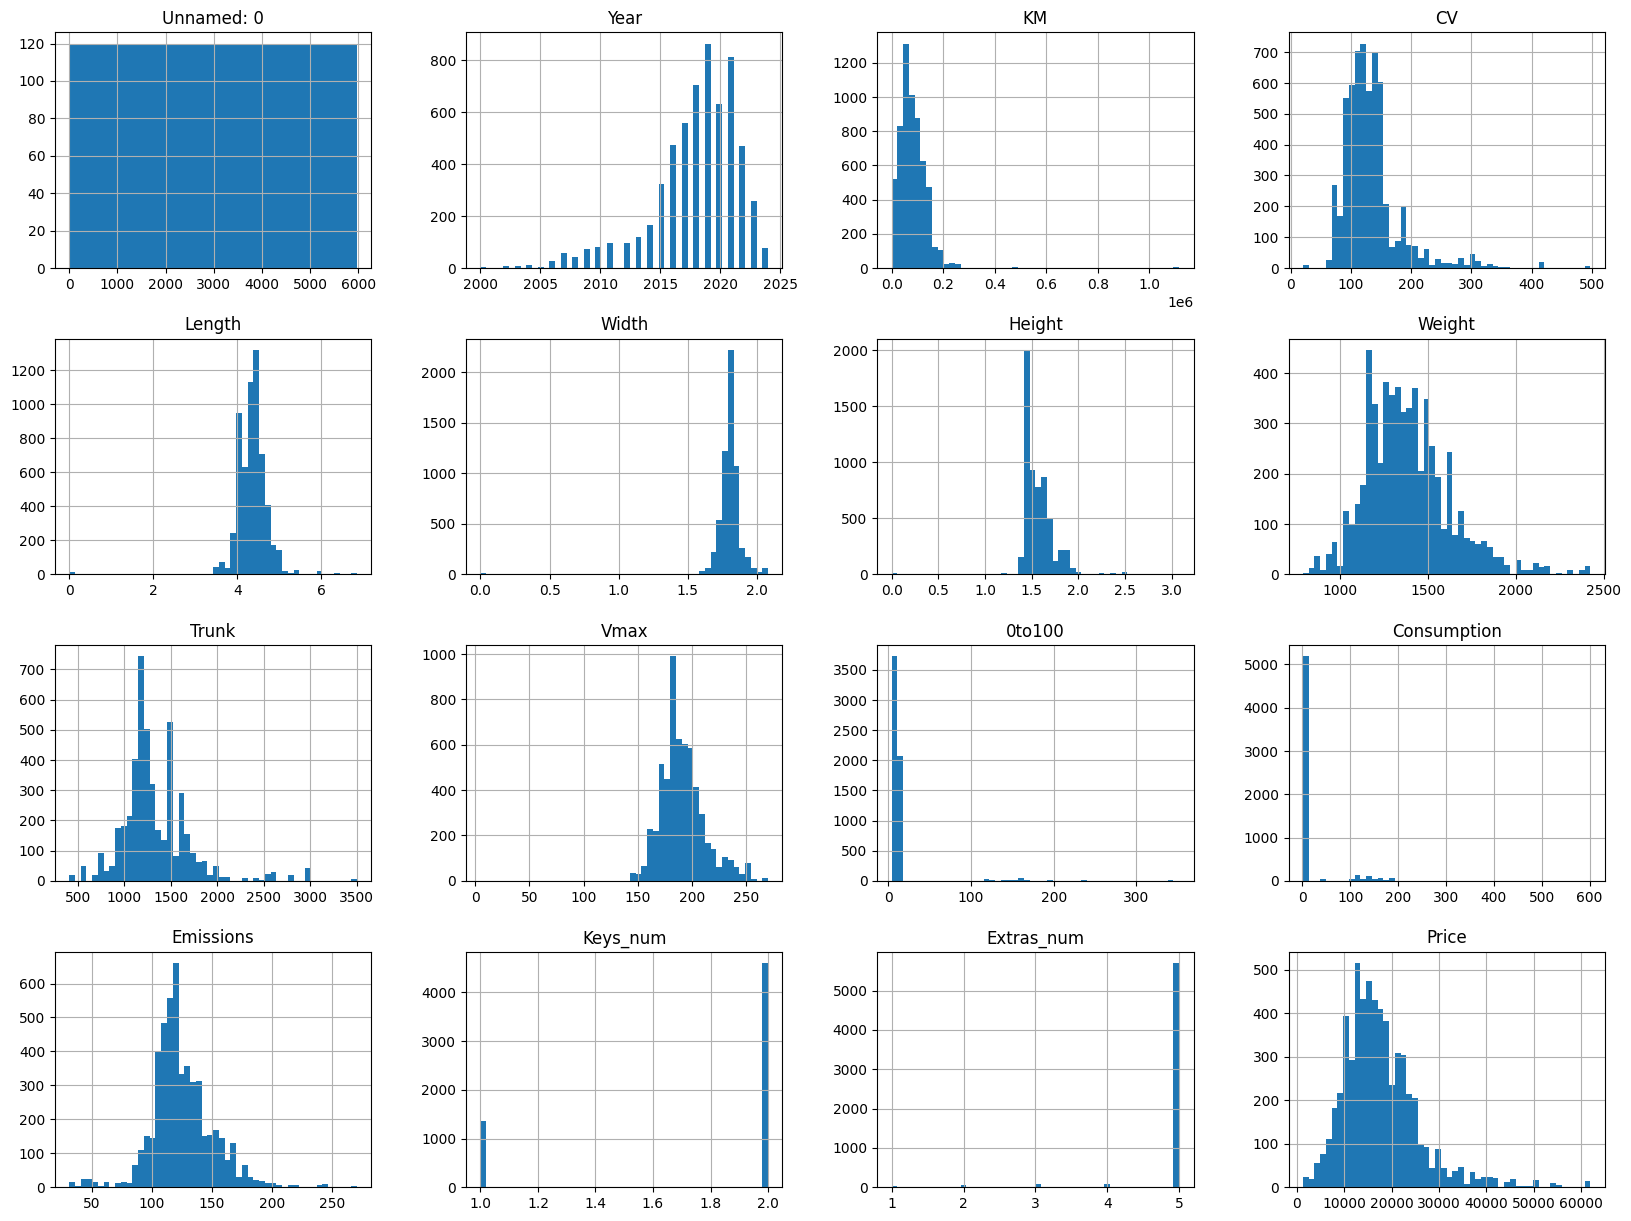

In [50]:
print("\nEstadísticas descriptivas:")
print(dftrain.describe())
#grafic de les dades en histograma
dftrain.hist(bins=50, figsize=(20,15))
plt.show()

In [51]:
#veiem que hi ha columnes amb -s que representen valors nuls
#les substituim per NaN
dftrain.replace("-", np.nan, inplace=True)

C:\Users\marcd\AppData\Local\Temp\ipykernel_22848\562233532.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dftrain.replace("-", np.nan, inplace=True)


In [52]:
# Mirem si hi ha nans a les dades de train

missing_percent_train = dftrain.isnull().mean() * 100

missing_percent_train = missing_percent_train.sort_values(ascending=False)

print("Percentatge de dades del train que falten per variable:\n")
print(missing_percent_train)
#treiem tank ja que esta buida sencera
dftrain = dftrain.drop(columns=["Tank"])



Percentatge de dades del train que falten per variable:

Tank            100.000000
Trunk            22.769128
Location         18.951950
Emissions        14.716223
Consumption       3.047045
Vmax              2.645237
0to100            0.435292
Sticker           0.418550
Weight            0.334840
Width             0.150678
Height            0.066968
KM                0.000000
Name              0.000000
Brand             0.000000
Unnamed: 0        0.000000
Year              0.000000
CV                0.000000
Fuel              0.000000
Length            0.000000
Transmission      0.000000
One_owner         0.000000
Keys_num          0.000000
Extras_num        0.000000
Price             0.000000
dtype: float64


In [53]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from collections import Counter

# Copia del dataframe
df = dftrain.copy()

# -------------------------
# 1. IMPUTACIÓ NUMÈRICA amb KNN
# -------------------------

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(df[num_cols])

imputer_num = KNNImputer(n_neighbors=5)
X_num_imputed_scaled = imputer_num.fit_transform(X_num_scaled)
X_num_imputed = scaler.inverse_transform(X_num_imputed_scaled)

df[num_cols] = X_num_imputed


# -------------------------
# 2. IMPUTACIÓ STICKER (moda)
# -------------------------

df["Sticker"] = df["Sticker"].fillna(df["Sticker"].mode()[0])


# -------------------------
# 3. IMPUTACIÓ LOCATION (KNN CORRECTE)
# -------------------------

# Variables que faran servir per buscar veïns (només numèriques)
X_num = df[num_cols].values

# Escalem per fer distàncies correctes
X_scaled = scaler.fit_transform(X_num)

# Per cada fila mancant en Location
loc_missing_idx = df["Location"].isna()

for idx in np.where(loc_missing_idx)[0]:

    # Distància a TOTES les altres files
    dists = np.sqrt(np.sum((X_scaled - X_scaled[idx])**2, axis=1))
    
    # Ordenem per distància i agafem els k=5 veïns més propers (excloent ell mateix)
    nn_idx = np.argsort(dists)[1:6]

    # Categories dels veïns
    neighbor_cats = df.iloc[nn_idx]["Location"].dropna()

    # Assignem la moda dels veïns
    if len(neighbor_cats) > 0:
        df.at[idx, "Location"] = Counter(neighbor_cats).most_common(1)[0][0]
    else:
        # Si tots veïns tenen també NA → assignem "Missing" com a fallback segur
        df.at[idx, "Location"] = "Missing"


# -------------------------
# 4. RESULTATS
# -------------------------

print(df.isnull().sum())

dftrain = df.copy()


Unnamed: 0      0
Brand           0
Name            0
Sticker         0
Year            0
KM              0
Fuel            0
CV              0
Transmission    0
One_owner       0
Location        0
Length          0
Width           0
Height          0
Weight          0
Trunk           0
Vmax            0
0to100          0
Consumption     0
Emissions       0
Keys_num        0
Extras_num      0
Price           0
dtype: int64


In [54]:
"""
# UNA ALTRA MANERA DE ELIMINAR ELS NANS


#numeriques amb pocs NaNs → mitjana
num_pocs_nans = ["Consumption", "Vmax", "0to100", "Weight", "Width", "Height"]

for col in num_pocs_nans:
    dftrain[col].fillna(dftrain[col].mean(), inplace=True)

#categoriquees amb pocs NaNs → moda
cat_pocs_nans = ["Sticker"]   
for col in cat_pocs_nans:
    mode_val = dftrain[col].mode()
    fill_val = mode_val[0] if not mode_val.empty else "Unknown"
    dftrain[col].fillna(fill_val, inplace=True)

"""

'\n# UNA ALTRA MANERA DE ELIMINAR ELS NANS\n\n\n#numeriques amb pocs NaNs → mitjana\nnum_pocs_nans = ["Consumption", "Vmax", "0to100", "Weight", "Width", "Height"]\n\nfor col in num_pocs_nans:\n    dftrain[col].fillna(dftrain[col].mean(), inplace=True)\n\n#categoriquees amb pocs NaNs → moda\ncat_pocs_nans = ["Sticker"]   \nfor col in cat_pocs_nans:\n    mode_val = dftrain[col].mode()\n    fill_val = mode_val[0] if not mode_val.empty else "Unknown"\n    dftrain[col].fillna(fill_val, inplace=True)\n\n'

In [55]:
print(dftrain.head())

   Unnamed: 0    Brand            Name Sticker    Year       KM      Fuel  \
0         0.0     Opel      Opel Corsa       C  2022.0  47707.0    Diésel   
1         1.0  Peugeot  Peugeot Rifter       C  2019.0  57194.0    Diésel   
2         2.0  Renault  Renault Kadjar       C  2017.0  66428.0    Diésel   
3         3.0    Dacia   Dacia Sandero       C  2016.0  48430.0  Gasolina   
4         4.0   Nissan  Nissan QASHQAI       C  2020.0  72209.0  Gasolina   

      CV Transmission  One_owner  ... Height  Weight   Trunk   Vmax  0to100  \
0  102.0       MANUAL       True  ...   1.43  1165.0  1069.0  188.0    10.2   
1  130.0         AUTO       True  ...   1.82  1430.0  1355.0  179.0     4.3   
2  110.0       MANUAL      False  ...   1.61  1380.0  1478.0  182.0    11.9   
3   75.0       MANUAL       True  ...   1.52   941.0  1200.0  162.0    14.5   
4  160.0         AUTO      False  ...   1.59  1315.0  1598.0  198.0     9.9   

   Consumption  Emissions  Keys_num  Extras_num    Price  
0  

In [56]:
"""# Pasem a numèriques les variables categòriques
sticker = LabelEncoder()
fuel = LabelEncoder()
transmission = LabelEncoder()
owner = LabelEncoder()
name= LabelEncoder()
brand= LabelEncoder()   
location = LabelEncoder()
#pasem de dades categoriques a numeriques
dftrain["Sticker"] = sticker.fit_transform(dftrain["Sticker"])
dftrain["Fuel"] = fuel.fit_transform(dftrain["Fuel"])
dftrain["Transmission"] = transmission.fit_transform(dftrain["Transmission"])
dftrain["One_owner"] = owner.fit_transform(dftrain["One_owner"])
dftrain["Name"] = name.fit_transform(dftrain["Name"])
dftrain["Brand"] = brand.fit_transform(dftrain["Brand"])
dftrain["Location"] = location.fit_transform(dftrain["Location"])"""

'# Pasem a numèriques les variables categòriques\nsticker = LabelEncoder()\nfuel = LabelEncoder()\ntransmission = LabelEncoder()\nowner = LabelEncoder()\nname= LabelEncoder()\nbrand= LabelEncoder()   \nlocation = LabelEncoder()\n#pasem de dades categoriques a numeriques\ndftrain["Sticker"] = sticker.fit_transform(dftrain["Sticker"])\ndftrain["Fuel"] = fuel.fit_transform(dftrain["Fuel"])\ndftrain["Transmission"] = transmission.fit_transform(dftrain["Transmission"])\ndftrain["One_owner"] = owner.fit_transform(dftrain["One_owner"])\ndftrain["Name"] = name.fit_transform(dftrain["Name"])\ndftrain["Brand"] = brand.fit_transform(dftrain["Brand"])\ndftrain["Location"] = location.fit_transform(dftrain["Location"])'

In [57]:
#crear noves mitjanes, per exemple preu mitjà per marca i model o preu per model NOU
import pandas as pd

# --- Basic aggregations per Brand ---
dftrain['brand_mean_price'] = dftrain.groupby('Brand')['Price'].transform('mean')
dftrain['brand_max_price']  = dftrain.groupby('Brand')['Price'].transform('max')
dftrain['brand_min_price']  = dftrain.groupby('Brand')['Price'].transform('min')

# --- Aggregations per Model (Brand + Name) ---
dftrain['model_mean_price'] = dftrain.groupby(['Brand', 'Name'])['Price'].transform('mean')
dftrain['model_max_price']  = dftrain.groupby(['Brand', 'Name'])['Price'].transform('max')
dftrain['model_min_price']  = dftrain.groupby(['Brand', 'Name'])['Price'].transform('min')

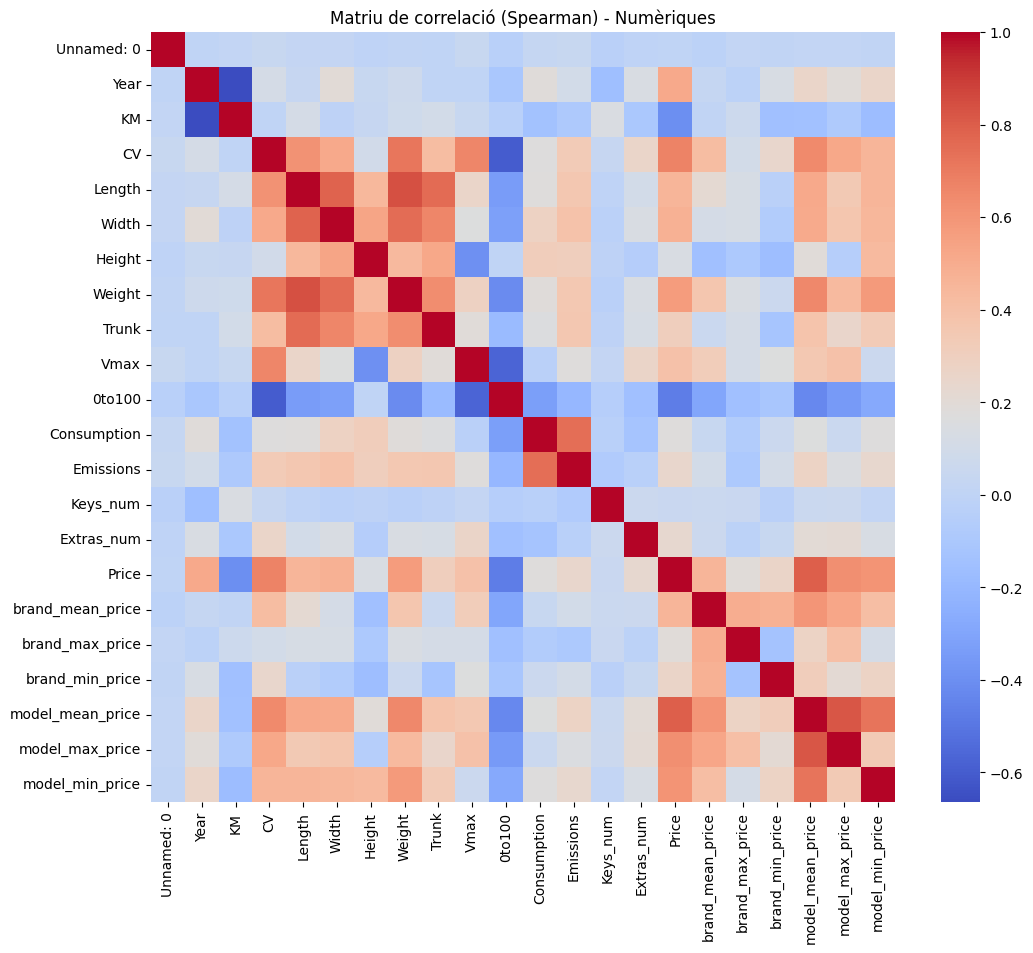

Correlació combinada amb Price:
Price               1.000000
Name                0.839347
model_mean_price    0.793910
CV                  0.674583
model_max_price     0.627756
model_min_price     0.605311
Weight              0.573670
Brand               0.525604
Year                0.517169
Transmission        0.490125
Width               0.476452
Length              0.459216
brand_mean_price    0.459151
Vmax                0.391121
Sticker             0.369124
Trunk               0.310719
Fuel                0.293703
brand_min_price     0.259938
Emissions           0.244075
Location            0.237634
Extras_num          0.229306
brand_max_price     0.188860
Consumption         0.179618
Height              0.141091
Keys_num            0.048869
Unnamed: 0          0.000368
KM                 -0.403095
0to100             -0.470578
dtype: float64


In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------
# 1️⃣ Separar variables
# -------------------------
num_cols = dftrain.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = dftrain.select_dtypes(include=["object"]).columns.tolist()

# -------------------------
# 2️⃣ Correlació Spearman (numèriques)
# -------------------------
corr_num = dftrain[num_cols].corr(method="spearman")

# Correlació amb Price
corr_price_num = corr_num["Price"].sort_values(ascending=False)

# Opcional: heatmap de correlacions numèriques
plt.figure(figsize=(12,10))
sns.heatmap(corr_num, cmap="coolwarm", annot=False)
plt.title("Matriu de correlació (Spearman) - Numèriques")
plt.show()

# -------------------------
# 3️⃣ Correlation Ratio (categòriques)
# -------------------------
def correlation_ratio(categories, values):
    """Correlació entre variable categòrica i numèrica (Price)"""
    categories = np.array(categories)
    values = np.array(values)
    cat_levels = np.unique(categories)
    
    total_mean = np.mean(values)
    numerator = sum([
        len(values[categories==cat]) * (np.mean(values[categories==cat]) - total_mean)**2
        for cat in cat_levels
    ])
    denominator = sum((values - total_mean)**2)
    
    return np.sqrt(numerator / denominator) if denominator != 0 else 0

corr_cat = {}
for col in cat_cols:
    corr_cat[col] = correlation_ratio(dftrain[col], dftrain["Price"])

# Ordenar
corr_cat = dict(sorted(corr_cat.items(), key=lambda item: item[1], reverse=True))

# -------------------------
# 4️⃣ Combinar numèriques i categòriques
# -------------------------
series_num = pd.Series(corr_price_num)
series_cat = pd.Series(corr_cat)

corr_combined = pd.concat([series_num, series_cat])
corr_combined = corr_combined.sort_values(ascending=False)

print("Correlació combinada amb Price:")
print(corr_combined)


In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# -----------------------------------
# 1️⃣ Variables
# -----------------------------------
num_cols_to_scale = [
    "Year", "KM", "CV", "Length", "Width", "Height", "Weight",
    "Trunk", "Vmax", "0to100", "Consumption", "Emissions",
    "Keys_num", "Extras_num",
    "brand_mean_price", "brand_max_price", "brand_min_price",
    "model_mean_price", "model_max_price", "model_min_price"
]

cat_ohe_cols = ["Sticker", "Fuel", "Transmission"]  # poques categories
cat_te_cols = ["Brand","Name", "Location"]                            # moltes categories

bool_cols = dftrain.select_dtypes(include=[bool]).columns.tolist()



# -----------------------------------
# 2️⃣ Target Encoding
# -----------------------------------
df_te = dftrain.copy()
for col in cat_te_cols:
    te = df_te.groupby(col)["Price"].mean()
    df_te[col + "_TE"] = df_te[col].map(te)

te_cols_new = [col + "_TE" for col in cat_te_cols]



#Passar a numèrica la variable One_owner

df_te["One_owner"] = df_te["One_owner"].astype(int)



# -----------------------------------
# 3️⃣ One-hot encoding per les poques categòriques
# -----------------------------------
ohe = OneHotEncoder(drop="first", sparse_output=False)
ohe_array = ohe.fit_transform(df_te[cat_ohe_cols])
ohe_cols = ohe.get_feature_names_out(cat_ohe_cols)
df_ohe = pd.DataFrame(ohe_array, columns=ohe_cols, index=df_te.index)

# -----------------------------------
# 4️⃣ Escalat de numèriques
# -----------------------------------
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_te[num_cols_to_scale])
df_scaled = pd.DataFrame(scaled_array, columns=num_cols_to_scale, index=df_te.index)

# -----------------------------------
# 5️⃣ Concatenar tot
# -----------------------------------
df_final = pd.concat([df_scaled, df_ohe, df_te[te_cols_new], df_te[bool_cols], df_te["Price"]], axis=1)

# -----------------------------------
# 6️⃣ Separar X i y
# -----------------------------------
X = df_final.drop(columns=["Price"])
y = df_final["Price"]

print(df_final.head())


       Year        KM        CV    Length     Width    Height    Weight  \
0  1.087942 -0.595708 -0.644779 -0.725735 -0.269508 -0.739005 -0.924807   
1  0.270926 -0.429414 -0.073151  0.129531  0.439627  1.362167  0.176627   
2 -0.273752 -0.267556 -0.481457  0.255306  0.350985  0.230767 -0.031190   
3 -0.546091 -0.583035 -1.195993 -0.725735 -0.624076 -0.254119 -1.855830   
4  0.543264 -0.166223  0.539309  0.104376  0.085059  0.123014 -0.301353   

      Trunk      Vmax    0to100  ...  Fuel_GNC  Fuel_Gasolina  Fuel_Híbrido  \
0 -0.713341 -0.123165 -0.141901  ...       0.0            0.0           0.0   
1  0.005873 -0.554348 -0.365804  ...       0.0            0.0           0.0   
2  0.315185 -0.410620 -0.077386  ...       0.0            0.0           0.0   
3 -0.383911 -1.368804  0.021283  ...       0.0            1.0           0.0   
4  0.616953  0.355927 -0.153285  ...       0.0            1.0           0.0   

   Fuel_Híbrido Enchufable  Transmission_MANUAL      Brand_TE       Name_T

In [60]:
"""
categorical_cols = ["Sticker", "Fuel", "Transmission", "Name", "Brand", "Location"]

dftrain = pd.get_dummies(dftrain, columns=categorical_cols, drop_first=True)

#print(dftrain.head())

bool_cols = dftrain.select_dtypes(include='bool').columns
# Pasem a numèriques totes les variables True/False
dftrain[bool_cols] = dftrain[bool_cols].astype(int)

# Comprovem
print(dftrain[bool_cols].head())

"""

'\ncategorical_cols = ["Sticker", "Fuel", "Transmission", "Name", "Brand", "Location"]\n\ndftrain = pd.get_dummies(dftrain, columns=categorical_cols, drop_first=True)\n\n#print(dftrain.head())\n\nbool_cols = dftrain.select_dtypes(include=\'bool\').columns\n# Pasem a numèriques totes les variables True/False\ndftrain[bool_cols] = dftrain[bool_cols].astype(int)\n\n# Comprovem\nprint(dftrain[bool_cols].head())\n\n'

In [61]:
"""print("Correspondències valors de la variable Sticker:\n")
for i, cat in enumerate(sticker.classes_):
    print(i, "->", cat)

print("\nCorrespondències valors de la variable Fuel:\n")
for i, cat in enumerate(fuel.classes_):
    print(i, "->", cat)

print("\nCorrespondències valors de la variable Transmission:\n")
for i, cat in enumerate(transmission.classes_):
    print(i, "->", cat)

print("\nCorrespondències valors de la variable One_owner:\n")
for i, cat in enumerate(owner.classes_):
    print(i, "->", cat)"""


'print("Correspondències valors de la variable Sticker:\n")\nfor i, cat in enumerate(sticker.classes_):\n    print(i, "->", cat)\n\nprint("\nCorrespondències valors de la variable Fuel:\n")\nfor i, cat in enumerate(fuel.classes_):\n    print(i, "->", cat)\n\nprint("\nCorrespondències valors de la variable Transmission:\n")\nfor i, cat in enumerate(transmission.classes_):\n    print(i, "->", cat)\n\nprint("\nCorrespondències valors de la variable One_owner:\n")\nfor i, cat in enumerate(owner.classes_):\n    print(i, "->", cat)'

In [62]:
#grafic de les dades en histograma
#dftrain.hist(bins=50, figsize=(20,15))
#plt.show()

In [63]:
"""

#normalitzem les dades
scaler = StandardScaler()

#deixem fora les columnes que no cal normalitzar
cols_to_scale=[
    "Year",
    "KM",
    "CV",
    "Length",
    "Width",
    "Height",
    "Weight",
    "Trunk",
    "Vmax",
    "0to100",
    "Consumption",
    "Emissions",
    "Keys_num",
    "Extras_num",
    "brand_mean_price",
    "brand_max_price",
    "brand_min_price",
    "model_mean_price",
    "model_max_price",
    "model_min_price",
]


df_scaled_values = scaler.fit_transform(dftrain[cols_to_scale])
df_scaled = pd.DataFrame(df_scaled_values, columns=cols_to_scale, index=df.index)
df_final = pd.concat([df_scaled,dftrain[bool_cols],dftrain["Price"]], axis=1)
print(df_final.head())

"""

'\n\n#normalitzem les dades\nscaler = StandardScaler()\n\n#deixem fora les columnes que no cal normalitzar\ncols_to_scale=[\n    "Year",\n    "KM",\n    "CV",\n    "Length",\n    "Width",\n    "Height",\n    "Weight",\n    "Trunk",\n    "Vmax",\n    "0to100",\n    "Consumption",\n    "Emissions",\n    "Keys_num",\n    "Extras_num",\n    "brand_mean_price",\n    "brand_max_price",\n    "brand_min_price",\n    "model_mean_price",\n    "model_max_price",\n    "model_min_price",\n]\n\n\ndf_scaled_values = scaler.fit_transform(dftrain[cols_to_scale])\ndf_scaled = pd.DataFrame(df_scaled_values, columns=cols_to_scale, index=df.index)\ndf_final = pd.concat([df_scaled,dftrain[bool_cols],dftrain["Price"]], axis=1)\nprint(df_final.head())\n\n'

In [64]:
#COMPROVACIÓ NANS

missing_percent_train = dftrain.isnull().mean() * 100

missing_percent_train = missing_percent_train.sort_values(ascending=False)

print("Percentatge de dades del train que falten per variable:\n")
print(missing_percent_train)

Percentatge de dades del train que falten per variable:

Unnamed: 0          0.0
Brand               0.0
Name                0.0
Sticker             0.0
Year                0.0
KM                  0.0
Fuel                0.0
CV                  0.0
Transmission        0.0
One_owner           0.0
Location            0.0
Length              0.0
Width               0.0
Height              0.0
Weight              0.0
Trunk               0.0
Vmax                0.0
0to100              0.0
Consumption         0.0
Emissions           0.0
Keys_num            0.0
Extras_num          0.0
Price               0.0
brand_mean_price    0.0
brand_max_price     0.0
brand_min_price     0.0
model_mean_price    0.0
model_max_price     0.0
model_min_price     0.0
dtype: float64


In [65]:
"""X = df_final.drop(columns=["Price"])
y = df_final["Price"]"""


'X = df_final.drop(columns=["Price"])\ny = df_final["Price"]'

In [66]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    BayesianRidge, SGDRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, make_scorer

import numpy as np
import pandas as pd

# --- KFold ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- MODELS ---
modelos_estimadores = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "BayesianRidge": BayesianRidge(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42, max_depth=5),
    "RandomForest": RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    #"SVR_linear": SVR(kernel="linear"),
    #"SVR_rbf": SVR(kernel="rbf"),
    "DecisionTree_max_depth3": DecisionTreeRegressor(max_depth=3, random_state=42),
    "RandomForest_max_depth10": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
    "GradientBoosting_lr05": GradientBoostingRegressor(learning_rate=0.05, n_estimators=50, max_depth=3, random_state=42),
    "ElasticNet_l1": ElasticNet(alpha=0.01, l1_ratio=1.0),
    "ElasticNet_l2": ElasticNet(alpha=0.01, l1_ratio=0.0)
    #,"SGDRegressor_huber": SGDRegressor(loss="huber", max_iter=1000, tol=1e-3, random_state=42)
}

scoring = make_scorer(mean_squared_error, greater_is_better=False)

mse_modelos = {}
mape_modelos = {}

print("\n=== CALCULANT MSE I MAPE DE TOTS ELS MODELS ===\n")

for nombre_modelo, modelo in modelos_estimadores.items():

    print(f"🔄 Processant {nombre_modelo}...")

    # --- MSE (mitjançant cross_val_score)
    scores = cross_val_score(modelo, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    mse_mean = -scores.mean()
    mse_modelos[nombre_modelo] = mse_mean

    # --- MAPE (mitjançant cross_val_predict)
    y_pred = cross_val_predict(modelo, X, y, cv=cv, n_jobs=-1)
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    mape_modelos[nombre_modelo] = mape

    # Prints immediats per poder veure el progrés
    print(f"    ➤ MSE    = {mse_mean:.2f}")
    print(f"    ➤ MAPE   = {mape:.2f}%\n")

# ---------------------------------------------------
# Resultats finals
# ---------------------------------------------------

print("\n=== RESULTATS FINALS ===")

# Millor model per MSE (mínim)
best_model = min(mse_modelos, key=mse_modelos.get)
print(f"\n🏆 Millor model (MSE): {best_model} amb MSE = {mse_modelos[best_model]:.2f}")

# Models amb MSE > 8.000.000
print("\n⚠️ Models amb MSE > 8.000.000:")
for nombre_modelo, mse_mean in mse_modelos.items():
    if mse_mean > 8_000_000:
        print(f"   {nombre_modelo} - MSE: {mse_mean:.2f}")

# Ranking per MAPE
best_mape_model = min(mape_modelos, key=mape_modelos.get)
print(f"\n🏅 Millor model (MAPE): {best_mape_model} amb MAPE = {mape_modelos[best_mape_model]:.2f}%")


=== CALCULANT MSE I MAPE DE TOTS ELS MODELS ===

🔄 Processant LinearRegression...
    ➤ MSE    = 8351399.69
    ➤ MAPE   = 14.22%

🔄 Processant Ridge...
    ➤ MSE    = 8348991.41
    ➤ MAPE   = 14.22%

🔄 Processant Lasso...
    ➤ MSE    = 8351314.90
    ➤ MAPE   = 14.22%

🔄 Processant ElasticNet...
    ➤ MSE    = 8408789.99
    ➤ MAPE   = 14.22%

🔄 Processant BayesianRidge...
    ➤ MSE    = 19072982.37
    ➤ MAPE   = 20.90%

🔄 Processant SGDRegressor...
    ➤ MSE    = 21258395197268475746830929379721216.00
    ➤ MAPE   = 798172924925344.38%

🔄 Processant DecisionTree...
    ➤ MSE    = 11152256.91
    ➤ MAPE   = 14.84%

🔄 Processant RandomForest...
    ➤ MSE    = 8146127.16
    ➤ MAPE   = 12.88%

🔄 Processant GradientBoosting...
    ➤ MSE    = 4687295.29
    ➤ MAPE   = 10.36%

🔄 Processant AdaBoost...
    ➤ MSE    = 10450545.15
    ➤ MAPE   = 20.73%

🔄 Processant KNeighbors...
    ➤ MSE    = 4903543.57
    ➤ MAPE   = 6.44%

🔄 Processant DecisionTree_max_depth3...
    ➤ MSE    = 1985258

In [67]:
# ELIMINEM ELS PITJORS MODELS 

del modelos_estimadores["SGDRegressor"]
del modelos_estimadores["BayesianRidge"]
del modelos_estimadores["DecisionTree_max_depth3"]
del modelos_estimadores["DecisionTree"]
del modelos_estimadores["AdaBoost"]

In [68]:
# MIREM LES MILLORS COLUMNES DELS MILLORS MODELS
"""
# --- KFold para cross-validation ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)


# --- Diccionario para guardar las variables seleccionadas ---
sfs_selected_features = {}

print("\n=== INICIANDO SELECCIÓN DE FEATURES ===")
print("Modelos totales:", len(modelos_estimadores))

# --- Bucle sobre modelos ---
for nombre_modelo, modelo in modelos_estimadores.items():
    print(f"\nProcesando {nombre_modelo}...")

    try:
        sfs = SequentialFeatureSelector(
            modelo,
            n_features_to_select="auto",   # BEST: selecciona número óptimo de features
            direction="forward",
            scoring="neg_mean_squared_error",
            cv=cv,
            n_jobs=-1
        )

        sfs.fit(X, y)
        selected_features = list(X.columns[sfs.get_support()])
        sfs_selected_features[nombre_modelo] = selected_features

        print(f"FEATURES seleccionados ({nombre_modelo}): {selected_features}")

    except Exception as e:
        print(f" Error en {nombre_modelo}: {e}")
        sfs_selected_features[nombre_modelo] = None


print("\n=== RESULTADO FINAL ===")
for modelo, features in sfs_selected_features.items():
    print(f"{modelo}: {features}")

"""

'\n# --- KFold para cross-validation ---\ncv = KFold(n_splits=5, shuffle=True, random_state=42)\n\n\n# --- Diccionario para guardar las variables seleccionadas ---\nsfs_selected_features = {}\n\nprint("\n=== INICIANDO SELECCIÓN DE FEATURES ===")\nprint("Modelos totales:", len(modelos_estimadores))\n\n# --- Bucle sobre modelos ---\nfor nombre_modelo, modelo in modelos_estimadores.items():\n    print(f"\nProcesando {nombre_modelo}...")\n\n    try:\n        sfs = SequentialFeatureSelector(\n            modelo,\n            n_features_to_select="auto",   # BEST: selecciona número óptimo de features\n            direction="forward",\n            scoring="neg_mean_squared_error",\n            cv=cv,\n            n_jobs=-1\n        )\n\n        sfs.fit(X, y)\n        selected_features = list(X.columns[sfs.get_support()])\n        sfs_selected_features[nombre_modelo] = selected_features\n\n        print(f"FEATURES seleccionados ({nombre_modelo}): {selected_features}")\n\n    except Exception a

In [69]:
# Millors models amb els features òptims

"""
=== RESULTADO FINAL ===
LinearRegression: ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_min_price', 'model_mean_price', 'Sticker_B', 'Sticker_ECO', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Brand_TE', 'Location_TE']
Ridge: ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_mean_price', 'brand_min_price', 'Sticker_B', 'Sticker_C', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Name_TE', 'Location_TE']
Lasso: ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_mean_price', 'brand_min_price', 'model_mean_price', 'Sticker_B', 'Sticker_ECO', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Location_TE']
ElasticNet: ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_mean_price', 'brand_min_price', 'Sticker_C', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Name_TE', 'Location_TE']
RandomForest: ['Year', 'KM', 'CV', 'Length', 'Trunk', 'Vmax', 'Emissions', 'Extras_num', 'model_mean_price', 'model_max_price', 'model_min_price', 'Sticker_B', 'Fuel_Eléctrico', 'Fuel_GLP', 'Fuel_Híbrido', 'Transmission_MANUAL', 'Location_TE']
GradientBoosting: ['Year', 'KM', 'CV', 'Width', 'Keys_num', 'brand_max_price', 'brand_min_price', 'model_mean_price', 'model_max_price', 'model_min_price', 'Sticker_C', 'Sticker_ECO', 'Fuel_GLP', 'Fuel_Gasolina', 'Fuel_Híbrido', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL']
KNeighbors: ['Year', 'KM', 'CV', 'Height', 'Weight', 'Consumption', 'Extras_num', 'model_mean_price', 'model_max_price', 'model_min_price', 'Sticker_B', 'Sticker_ECO', 'Fuel_Eléctrico', 'Fuel_GLP', 'Fuel_GNC', 'Fuel_Híbrido', 'Fuel_Híbrido Enchufable']
RandomForest_max_depth10: ['Year', 'KM', 'CV', 'Length', 'Height', 'Weight', 'Vmax', '0to100', 'Emissions', 'Keys_num', 'model_mean_price', 'model_max_price', 'model_min_price', 'Sticker_ECO', 'Transmission_MANUAL', 'Brand_TE', 'Location_TE']
GradientBoosting_lr05: ['Year', 'KM', 'CV', 'Width', 'Emissions', 'Keys_num', 'Extras_num', 'brand_max_price', 'model_mean_price', 'model_max_price', 'model_min_price', 'Sticker_ECO', 'Fuel_GLP', 'Fuel_GNC', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Location_TE']
ElasticNet_l1: ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_mean_price', 'brand_min_price', 'model_mean_price', 'Sticker_B', 'Sticker_ECO', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Location_TE']
ElasticNet_l2: ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_mean_price', 'brand_min_price', 'Sticker_C', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Name_TE', 'Location_TE']

"""

"\n=== RESULTADO FINAL ===\nLinearRegression: ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_min_price', 'model_mean_price', 'Sticker_B', 'Sticker_ECO', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Brand_TE', 'Location_TE']\nRidge: ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_mean_price', 'brand_min_price', 'Sticker_B', 'Sticker_C', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Name_TE', 'Location_TE']\nLasso: ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_mean_price', 'brand_min_price', 'model_mean_price', 'Sticker_B', 'Sticker_ECO', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Location_TE']\nElasticNet: ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_mean_price', 'brand_min_price', 'Sticker_C', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido', 'Fuel_Híbrido Enchufable', 'Tran

In [70]:
# Calculem MSE i MAPE dels models amb els features trobats

sfs_selected_features = {
    "LinearRegression": ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_min_price', 'model_mean_price', 'Sticker_B', 'Sticker_ECO', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Brand_TE', 'Location_TE'],
    "Ridge": ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_mean_price', 'brand_min_price', 'Sticker_B', 'Sticker_C', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Name_TE', 'Location_TE'],
    "Lasso": ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_mean_price', 'brand_min_price', 'model_mean_price', 'Sticker_B', 'Sticker_ECO', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Location_TE'],
    "ElasticNet": ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_mean_price', 'brand_min_price', 'Sticker_C', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Name_TE', 'Location_TE'],
    "RandomForest": ['Year', 'KM', 'CV', 'Length', 'Trunk', 'Vmax', 'Emissions', 'Extras_num', 'model_mean_price', 'model_max_price', 'model_min_price', 'Sticker_B', 'Fuel_Eléctrico', 'Fuel_GLP', 'Fuel_Híbrido', 'Transmission_MANUAL', 'Location_TE'],
    "GradientBoosting": ['Year', 'KM', 'CV', 'Width', 'Keys_num', 'brand_max_price', 'brand_min_price', 'model_mean_price', 'model_max_price', 'model_min_price', 'Sticker_C', 'Sticker_ECO', 'Fuel_GLP', 'Fuel_Gasolina', 'Fuel_Híbrido', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL'],
    "KNeighbors": ['Year', 'KM', 'CV', 'Height', 'Weight', 'Consumption', 'Extras_num', 'model_mean_price', 'model_max_price', 'model_min_price', 'Sticker_B', 'Sticker_ECO', 'Fuel_Eléctrico', 'Fuel_GLP', 'Fuel_GNC', 'Fuel_Híbrido', 'Fuel_Híbrido Enchufable'],
    "RandomForest_max_depth10": ['Year', 'KM', 'CV', 'Length', 'Height', 'Weight', 'Vmax', '0to100', 'Emissions', 'Keys_num', 'model_mean_price', 'model_max_price', 'model_min_price', 'Sticker_ECO', 'Transmission_MANUAL', 'Brand_TE', 'Location_TE'],
    "GradientBoosting_lr05": ['Year', 'KM', 'CV', 'Width', 'Emissions', 'Keys_num', 'Extras_num', 'brand_max_price', 'model_mean_price', 'model_max_price', 'model_min_price', 'Sticker_ECO', 'Fuel_GLP', 'Fuel_GNC', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Location_TE'],
    "ElasticNet_l1": ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_mean_price', 'brand_min_price', 'model_mean_price', 'Sticker_B', 'Sticker_ECO', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Location_TE'],
    "ElasticNet_l2": ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Keys_num', 'brand_mean_price', 'brand_min_price', 'Sticker_C', 'Fuel_Eléctrico', 'Fuel_Gasolina', 'Fuel_Híbrido', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Name_TE', 'Location_TE']
}


# --- KFold ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Scorer per MSE ---
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# --- Diccionaris per guardar resultats ---
mse_modelos = {}
mape_modelos = {}


print("\n=== CALCULANT MSE I MAPE AMB MILLORS FEATURES ===\n")

for nombre_modelo, modelo in modelos_estimadores.items():
    features = sfs_selected_features[nombre_modelo]
    X_model = X[features]

    print(f"🔄 Processant {nombre_modelo} amb {len(features)} features...")

    # MSE
    scores = cross_val_score(modelo, X_model, y, cv=cv, scoring=scoring, n_jobs=-1)
    mse_mean = -scores.mean()
    mse_modelos[nombre_modelo] = mse_mean

    # MAPE
    y_pred = cross_val_predict(modelo, X_model, y, cv=cv, n_jobs=-1)
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    mape_modelos[nombre_modelo] = mape

    print(f"    ➤ MSE    = {mse_mean:.2f}")
    print(f"    ➤ MAPE   = {mape:.2f}%\n")

# Resultats finals
best_model = min(mse_modelos, key=mse_modelos.get)
print(f"\n🏆 Millor model (MSE) amb millors features: {best_model} amb MSE = {mse_modelos[best_model]:.2f}")
best_mape_model = min(mape_modelos, key=mape_modelos.get)
print(f"🏅 Millor model (MAPE) amb millors features: {best_mape_model} amb MAPE = {mape_modelos[best_mape_model]:.2f}%")


=== CALCULANT MSE I MAPE AMB MILLORS FEATURES ===

🔄 Processant LinearRegression amb 17 features...
    ➤ MSE    = 8452990.97
    ➤ MAPE   = 14.40%

🔄 Processant Ridge amb 17 features...
    ➤ MSE    = 8454166.71
    ➤ MAPE   = 14.40%

🔄 Processant Lasso amb 17 features...
    ➤ MSE    = 8452995.90
    ➤ MAPE   = 14.40%

🔄 Processant ElasticNet amb 17 features...
    ➤ MSE    = 8503505.62
    ➤ MAPE   = 14.23%

🔄 Processant RandomForest amb 17 features...
    ➤ MSE    = 8152599.18
    ➤ MAPE   = 12.89%

🔄 Processant GradientBoosting amb 17 features...
    ➤ MSE    = 4678822.63
    ➤ MAPE   = 10.44%

🔄 Processant KNeighbors amb 17 features...
    ➤ MSE    = 1439573.11
    ➤ MAPE   = 3.26%

🔄 Processant RandomForest_max_depth10 amb 17 features...
    ➤ MSE    = 1242538.39
    ➤ MAPE   = 4.20%

🔄 Processant GradientBoosting_lr05 amb 17 features...
    ➤ MSE    = 8028338.04
    ➤ MAPE   = 14.63%

🔄 Processant ElasticNet_l1 amb 17 features...
    ➤ MSE    = 8452995.90
    ➤ MAPE   = 14.40%

In [71]:
# Fem train_test_split juntament amb CV per veure si tenim Overfitting als models

from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# --- Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Diccionari per guardar resultats
results = {}

# Iterar sobre tots els models amb els millors features
for nombre_modelo, features in sfs_selected_features.items():
    modelo = modelos_estimadores[nombre_modelo]
    
    print(f"\n🔄 Processant {nombre_modelo} amb {len(features)} features...")
    
    # Cross-validation sobre el train set
    y_train_pred = cross_val_predict(modelo, X_train[features], y_train, cv=cv, n_jobs=-1)
    mse_cv = mean_squared_error(y_train, y_train_pred)
    mape_cv = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    
    # Entrenar model sobre tot el train i evaluar sobre test
    modelo.fit(X_train[features], y_train)
    y_test_pred = modelo.predict(X_test[features])
    mse_test = mean_squared_error(y_test, y_test_pred)
    mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    # Guardar resultats
    results[nombre_modelo] = {
        "MSE_CV": mse_cv,
        "MAPE_CV": mape_cv,
        "MSE_Test": mse_test,
        "MAPE_Test": mape_test
    }
    
    # Print immediat per cada model
    print(f"    ➤ CV MSE    = {mse_cv:.2f}")
    print(f"    ➤ CV MAPE   = {mape_cv:.2f}%")
    print(f"    ➤ Test MSE  = {mse_test:.2f}")
    print(f"    ➤ Test MAPE = {mape_test:.2f}%")

# Convertir a DataFrame per veure resum
df_results = pd.DataFrame(results).T
df_results = df_results.sort_values(by="MSE_Test")
print("\n=== RESUM COMPARATIU ===")
print(df_results)


🔄 Processant LinearRegression amb 17 features...
    ➤ CV MSE    = 8337034.85
    ➤ CV MAPE   = 14.18%
    ➤ Test MSE  = 8789732.12
    ➤ Test MAPE = 15.14%

🔄 Processant Ridge amb 17 features...
    ➤ CV MSE    = 8339362.72
    ➤ CV MAPE   = 14.18%
    ➤ Test MSE  = 8810497.79
    ➤ Test MAPE = 15.13%

🔄 Processant Lasso amb 17 features...
    ➤ CV MSE    = 8337049.98
    ➤ CV MAPE   = 14.18%
    ➤ Test MSE  = 8789852.59
    ➤ Test MAPE = 15.14%

🔄 Processant ElasticNet amb 17 features...
    ➤ CV MSE    = 8392244.25
    ➤ CV MAPE   = 14.03%
    ➤ Test MSE  = 9027401.13
    ➤ Test MAPE = 14.95%

🔄 Processant RandomForest amb 17 features...
    ➤ CV MSE    = 7909975.76
    ➤ CV MAPE   = 12.57%
    ➤ Test MSE  = 8848233.32
    ➤ Test MAPE = 13.41%

🔄 Processant GradientBoosting amb 17 features...
    ➤ CV MSE    = 4976733.27
    ➤ CV MAPE   = 10.46%
    ➤ Test MSE  = 4959451.20
    ➤ Test MAPE = 10.98%

🔄 Processant KNeighbors amb 17 features...
    ➤ CV MSE    = 2491358.84
    ➤ CV MA

c:\Users\marcd\OneDrive\Documentos\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e+10, tolerance: 3.046e+07
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [72]:
"""modelos_columnas = {
    "LinearRegression": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                         'Emissions', 'brand_mean_price', 'brand_min_price',
                         'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "Ridge": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
              'Emissions', 'brand_mean_price', 'brand_min_price',
              'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "Lasso": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
              'Emissions', 'brand_mean_price', 'brand_min_price',
              'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "ElasticNet": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                   'Emissions', 'brand_mean_price', 'brand_min_price',
                   'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "BayesianRidge": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                      'Emissions', 'brand_mean_price', 'brand_min_price',
                      'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "SGDRegressor": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                     'Emissions', 'brand_mean_price', 'brand_min_price',
                     'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "DecisionTree": ['Year', 'CV', 'Length', 'Height', '0to100', 'Consumption',
                     'Emissions', 'Keys_num', 'Extras_num',
                     'model_mean_price', 'model_max_price', 'model_min_price',
                     'Transmission'],

    "RandomForest": ['Year', 'KM', 'CV', 'Length', 'Height', 'Vmax', '0to100',
                     'Emissions', 'model_mean_price', 'model_max_price',
                     'model_min_price', 'Transmission', 'Location'],

    "GradientBoosting": ['Year', 'KM', 'CV', 'Width', 'Keys_num',
                         'brand_max_price', 'brand_min_price',
                         'model_mean_price', 'model_max_price',
                         'model_min_price', 'Brand', 'Transmission', 'Location'],

    "AdaBoost": ['Year', 'CV', 'Weight', 'Trunk', '0to100', 'Emissions',
                 'Keys_num', 'Extras_num', 'model_mean_price',
                 'Name', 'Fuel', 'One_owner', 'Location'],

    "KNeighbors": ['Year', 'KM', 'CV', 'Height', 'Weight', 'Trunk', 'Vmax',
                   'Consumption', 'Extras_num', 'model_mean_price',
                   'model_max_price', 'model_min_price', 'Transmission'],

    "SVR_linear": ['Year', 'KM', 'CV', 'Weight', 'Vmax', 'Emissions', 'Keys_num',
                   'brand_mean_price', 'model_mean_price',
                   'model_max_price', 'model_min_price', 'Sticker', 'Transmission'],

    "SVR_rbf": ['Year', 'KM', 'CV', 'Length', 'Width', 'Weight', 'Vmax',
                '0to100', 'model_mean_price', 'model_max_price',
                'model_min_price', 'Sticker', 'Transmission'],

    "DecisionTree_max_depth3": ['Year', 'Length', 'Width', 'Height', 'Weight',
                                'Trunk', 'Consumption', 'Keys_num', 'Extras_num',
                                'brand_mean_price', 'brand_max_price',
                                'brand_min_price', 'model_mean_price'],

    "RandomForest_max_depth10": ['Year', 'KM', 'CV', 'Length', 'Height', 'Weight',
                                 '0to100', 'Emissions', 'model_mean_price',
                                 'model_max_price', 'model_min_price',
                                 'Transmission', 'Location'],

    "GradientBoosting_lr05": ['Year', 'KM', 'CV', 'Consumption', 'Emissions',
                              'Keys_num', 'brand_max_price', 'model_mean_price',
                              'model_max_price', 'model_min_price', 'Brand',
                              'Transmission', 'Location'],

    "ElasticNet_l1": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                      'Emissions', 'brand_mean_price', 'brand_min_price',
                      'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "ElasticNet_l2": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                      'Emissions', 'brand_mean_price', 'brand_min_price',
                      'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "SGDRegressor_huber": ['Year', 'CV', 'Length', 'Weight', 'Vmax',
                           'brand_mean_price', 'model_mean_price',
                           'model_max_price', 'model_min_price', 'Brand',
                           'Sticker', 'Fuel', 'Location']
}
"""

'modelos_columnas = {\n    "LinearRegression": [\'Year\', \'KM\', \'CV\', \'Width\', \'Height\', \'Consumption\',\n                         \'Emissions\', \'brand_mean_price\', \'brand_min_price\',\n                         \'model_mean_price\', \'Sticker\', \'Fuel\', \'Transmission\'],\n\n    "Ridge": [\'Year\', \'KM\', \'CV\', \'Width\', \'Height\', \'Consumption\',\n              \'Emissions\', \'brand_mean_price\', \'brand_min_price\',\n              \'model_mean_price\', \'Sticker\', \'Fuel\', \'Transmission\'],\n\n    "Lasso": [\'Year\', \'KM\', \'CV\', \'Width\', \'Height\', \'Consumption\',\n              \'Emissions\', \'brand_mean_price\', \'brand_min_price\',\n              \'model_mean_price\', \'Sticker\', \'Fuel\', \'Transmission\'],\n\n    "ElasticNet": [\'Year\', \'KM\', \'CV\', \'Width\', \'Height\', \'Consumption\',\n                   \'Emissions\', \'brand_mean_price\', \'brand_min_price\',\n                   \'model_mean_price\', \'Sticker\', \'Fuel\', \'Transmiss

In [73]:
"""# ...existing code...
# --- Construir modelos_columnas expandiendo dummies para categorías ---
# Base (mantenemos las listas originales, con las columnas categóricas como placeholders)
base_modelos_columnas = {
    "LinearRegression": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                         'Emissions', 'brand_mean_price', 'brand_min_price',
                         'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "Ridge": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
              'Emissions', 'brand_mean_price', 'brand_min_price',
              'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "Lasso": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
              'Emissions', 'brand_mean_price', 'brand_min_price',
              'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "ElasticNet": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                   'Emissions', 'brand_mean_price', 'brand_min_price',
                   'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "BayesianRidge": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                      'Emissions', 'brand_mean_price', 'brand_min_price',
                      'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "SGDRegressor": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                     'Emissions', 'brand_mean_price', 'brand_min_price',
                     'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "DecisionTree": ['Year', 'CV', 'Length', 'Height', '0to100', 'Consumption',
                     'Emissions', 'Keys_num', 'Extras_num',
                     'model_mean_price', 'model_max_price', 'model_min_price',
                     'Transmission'],

    "RandomForest": ['Year', 'KM', 'CV', 'Length', 'Height', 'Vmax', '0to100',
                     'Emissions', 'model_mean_price', 'model_max_price',
                     'model_min_price', 'Transmission', 'Location'],

    "GradientBoosting": ['Year', 'KM', 'CV', 'Width', 'Keys_num',
                         'brand_max_price', 'brand_min_price',
                         'model_mean_price', 'model_max_price',
                         'model_min_price', 'Brand', 'Transmission', 'Location'],

    "AdaBoost": ['Year', 'CV', 'Weight', 'Trunk', '0to100', 'Emissions',
                 'Keys_num', 'Extras_num', 'model_mean_price',
                 'Name', 'Fuel', 'One_owner', 'Location'],

    "KNeighbors": ['Year', 'KM', 'CV', 'Height', 'Weight', 'Trunk', 'Vmax',
                   'Consumption', 'Extras_num', 'model_mean_price',
                   'model_max_price', 'model_min_price', 'Transmission'],

    "SVR_linear": ['Year', 'KM', 'CV', 'Weight', 'Vmax', 'Emissions', 'Keys_num',
                   'brand_mean_price', 'model_mean_price',
                   'model_max_price', 'model_min_price', 'Sticker', 'Transmission'],

    "SVR_rbf": ['Year', 'KM', 'CV', 'Length', 'Width', 'Weight', 'Vmax',
                '0to100', 'model_mean_price', 'model_max_price',
                'model_min_price', 'Sticker', 'Transmission'],

    "DecisionTree_max_depth3": ['Year', 'Length', 'Width', 'Height', 'Weight',
                                'Trunk', 'Consumption', 'Keys_num', 'Extras_num',
                                'brand_mean_price', 'brand_max_price',
                                'brand_min_price', 'model_mean_price'],

    "RandomForest_max_depth10": ['Year', 'KM', 'CV', 'Length', 'Height', 'Weight',
                                 '0to100', 'Emissions', 'model_mean_price',
                                 'model_max_price', 'model_min_price',
                                 'Transmission', 'Location'],

    "GradientBoosting_lr05": ['Year', 'KM', 'CV', 'Consumption', 'Emissions',
                              'Keys_num', 'brand_max_price', 'model_mean_price',
                              'model_max_price', 'model_min_price', 'Brand',
                              'Transmission', 'Location'],

    "ElasticNet_l1": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                      'Emissions', 'brand_mean_price', 'brand_min_price',
                      'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "ElasticNet_l2": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                      'Emissions', 'brand_mean_price', 'brand_min_price',
                      'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "SGDRegressor_huber": ['Year', 'CV', 'Length', 'Weight', 'Vmax',
                           'brand_mean_price', 'model_mean_price',
                           'model_max_price', 'model_min_price', 'Brand',
                           'Sticker', 'Fuel', 'Location']
}

# Columnas categóricas originales (las que hiciste get_dummies)
categorical_placeholders = ["Sticker", "Fuel", "Transmission", "Name", "Brand", "Location", "One_owner"]

def expand_features(feature_list, df_cols, cat_placeholders):
    expanded = []
    seen = set()
    for feat in feature_list:
        # Si la columna existe tal cual (numérica o label-encoded), añadirla
        if feat in df_cols and feat not in seen:
            expanded.append(feat); seen.add(feat); continue

        # Si es una de las categorías, añadir todos los dummies que empiecen por "feat_"
        if feat in cat_placeholders:
            prefix = feat + "_"
            matches = [c for c in df_cols if c.startswith(prefix)]
            # si no hay matches, intentar contains (por si get_dummies formó nombres diferentes)
            if not matches:
                matches = [c for c in df_cols if feat in c]
            matches = [c for c in matches if c not in seen]
            expanded.extend(matches)
            seen.update(matches)
            continue

        # Si no es categórica, buscar columna exacta o columnas que contengan el nombre (fallback)
        matches = [c for c in df_cols if c == feat or c.endswith("_" + feat) or feat in c]
        for m in matches:
            if m not in seen:
                expanded.append(m); seen.add(m)
    return expanded

# Expande para cada modelo usando las columnas actuales de df_final
df_cols = list(df_final.columns)  # df_final ya creado en el notebook
modelos_columnas = {}
for modelo, feats in base_modelos_columnas.items():
    modelos_columnas[modelo] = expand_features(feats, df_cols, categorical_placeholders)

# (Opcional) imprimir resumen rápido
for m, cols in modelos_columnas.items():
    print(f"{m}: {len(cols)} columnas")
# ...existing code...
print(modelos_columnas)

"""

'# ...existing code...\n# --- Construir modelos_columnas expandiendo dummies para categorías ---\n# Base (mantenemos las listas originales, con las columnas categóricas como placeholders)\nbase_modelos_columnas = {\n    "LinearRegression": [\'Year\', \'KM\', \'CV\', \'Width\', \'Height\', \'Consumption\',\n                         \'Emissions\', \'brand_mean_price\', \'brand_min_price\',\n                         \'model_mean_price\', \'Sticker\', \'Fuel\', \'Transmission\'],\n\n    "Ridge": [\'Year\', \'KM\', \'CV\', \'Width\', \'Height\', \'Consumption\',\n              \'Emissions\', \'brand_mean_price\', \'brand_min_price\',\n              \'model_mean_price\', \'Sticker\', \'Fuel\', \'Transmission\'],\n\n    "Lasso": [\'Year\', \'KM\', \'CV\', \'Width\', \'Height\', \'Consumption\',\n              \'Emissions\', \'brand_mean_price\', \'brand_min_price\',\n              \'model_mean_price\', \'Sticker\', \'Fuel\', \'Transmission\'],\n\n    "ElasticNet": [\'Year\', \'KM\', \'CV\', \

In [74]:
"""modelos_columnas = {
    "LinearRegression": list(df_final.columns),
    "Ridge": list(df_final.columns),
    "Lasso": list(df_final.columns),
    "ElasticNet": list(df_final.columns),
    "BayesianRidge": list(df_final.columns),
    "SGDRegressor": list(df_final.columns),
    "DecisionTree": list(df_final.columns),
    "RandomForest": list(df_final.columns),
    "GradientBoosting": list(df_final.columns),
    "AdaBoost": list(df_final.columns),
    "KNeighbors": list(df_final.columns),
    "SVR_linear": list(df_final.columns),
    "SVR_rbf": list(df_final.columns),
    "DecisionTree_max_depth3": list(df_final.columns),
    "RandomForest_max_depth10": list(df_final.columns),
    "GradientBoosting_lr05": list(df_final.columns),
    "ElasticNet_l1": list(df_final.columns),
    "ElasticNet_l2": list(df_final.columns),
    "SGDRegressor_huber": list(df_final.columns)
}"""

'modelos_columnas = {\n    "LinearRegression": list(df_final.columns),\n    "Ridge": list(df_final.columns),\n    "Lasso": list(df_final.columns),\n    "ElasticNet": list(df_final.columns),\n    "BayesianRidge": list(df_final.columns),\n    "SGDRegressor": list(df_final.columns),\n    "DecisionTree": list(df_final.columns),\n    "RandomForest": list(df_final.columns),\n    "GradientBoosting": list(df_final.columns),\n    "AdaBoost": list(df_final.columns),\n    "KNeighbors": list(df_final.columns),\n    "SVR_linear": list(df_final.columns),\n    "SVR_rbf": list(df_final.columns),\n    "DecisionTree_max_depth3": list(df_final.columns),\n    "RandomForest_max_depth10": list(df_final.columns),\n    "GradientBoosting_lr05": list(df_final.columns),\n    "ElasticNet_l1": list(df_final.columns),\n    "ElasticNet_l2": list(df_final.columns),\n    "SGDRegressor_huber": list(df_final.columns)\n}'

In [75]:
"""from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
from copy import deepcopy

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )



# --- Cross-validation ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # negativo para que cross_val_score funcione

# --- Diccionario para almacenar los resultados ---
model_scores = {}

# --- Evaluar cada modelo con sus variables seleccionadas ---
for nombre_modelo, modelo in modelos_estimadores.items():
    features = sfs_selected_features.get(nombre_modelo)
    
    if features is None or len(features) == 0:
        print(f"{nombre_modelo} no tiene variables seleccionadas, se omite.")
        model_scores[nombre_modelo] = None
        continue
    
    X_subset = X_train[[col for col in features if col in X_train.columns]]
    
    try:
        scores = cross_val_score(modelo, X_subset, y_train, cv=cv, scoring=mse_scorer, n_jobs=-1)
        mean_score = -np.mean(scores)  # convertir de negativo a positivo
        model_scores[nombre_modelo] = mean_score
        print(f"{nombre_modelo} - MSE promedio: {mean_score:.4f}")
    
    except Exception as e:
        print(f"Error evaluando {nombre_modelo}: {e}")
        model_scores[nombre_modelo] = None

# --- Elegir el mejor modelo ---
best_model = min((mse, mdl) for mdl, mse in model_scores.items() if mse is not None)
print(f"\nMejor modelo: {best_model[1]} con MSE = {best_model[0]:.4f}")
# Mostrar MSE CV (ya en model_scores) y MSE en test para cada modelo

model_test_scores = {}
print("\nComparativa CV vs Test MSE:")
for nombre_modelo, modelo in modelos_estimadores.items():
    cv_mse = model_scores.get(nombre_modelo)
    feats =sfs_selected_features.get(nombre_modelo)
    if cv_mse is None or not feats:
        print(f"{nombre_modelo}: CV MSE = {cv_mse} -> omitido (sin features o error CV).")
        continue

    cols = [c for c in feats if c in X_train.columns]
    if len(cols) == 0:
        print(f"{nombre_modelo}: no hay columnas válidas en train/test, omito test.")
        continue

    try:
        m = deepcopy(modelo)
        m.fit(X_train[cols], y_train)
        y_pred = m.predict(X_test[cols])
        test_mse = mean_squared_error(y_test, y_pred)
        model_test_scores[nombre_modelo] = test_mse

        ratio = test_mse / cv_mse if cv_mse > 0 else np.inf
        flag = ""


        print(f"{nombre_modelo}: CV MSE = {cv_mse:.2f} | Test MSE = {test_mse:.2f} | ratio={ratio:.2f}{flag}")

    except Exception as e:
        print(f"{nombre_modelo}: error calculando Test MSE: {e}")"""


'from sklearn.model_selection import cross_val_score, KFold\nfrom sklearn.metrics import mean_squared_error, make_scorer\nimport numpy as np\nfrom copy import deepcopy\n\nX_train, X_test, y_train, y_test = train_test_split(\n        X, y, test_size=0.2, random_state=42\n    )\n\n\n\n# --- Cross-validation ---\ncv = KFold(n_splits=5, shuffle=True, random_state=42)\nmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # negativo para que cross_val_score funcione\n\n# --- Diccionario para almacenar los resultados ---\nmodel_scores = {}\n\n# --- Evaluar cada modelo con sus variables seleccionadas ---\nfor nombre_modelo, modelo in modelos_estimadores.items():\n    features = sfs_selected_features.get(nombre_modelo)\n\n    if features is None or len(features) == 0:\n        print(f"{nombre_modelo} no tiene variables seleccionadas, se omite.")\n        model_scores[nombre_modelo] = None\n        continue\n\n    X_subset = X_train[[col for col in features if col in X_train.co

In [76]:
"""from sklearn.metrics import mean_squared_error

# --- ELEGIR EL MEJOR MODELO POR MSE_Test ---
best_model = min(results, key=lambda m: results[m]["MSE_Test"])
best_mse = results[best_model]["MSE_Test"]
best_mape = results[best_model]["MAPE_Test"]

print("\n=== MEJOR MODELO ===")
print(f"Mejor modelo : {best_model}")
print(f"MSE_Test     : {best_mse:,.4f}")
print(f"MAPE_Test    : {best_mape:.4f}%")

# -------------------------------------------------------------------------
# --- GRIDSEARCH PARA RandomForest_max_depth10 ---
# -------------------------------------------------------------------------

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = "neg_mean_squared_error"

target_name = "RandomForest_max_depth10"

# Features seleccionadas por SFS
features_rf = [f for f in sfs_selected_features.get(target_name, []) if f in X_train.columns]

print(f"\nIniciando GridSearchCV para {target_name} usando {len(features_rf)} features...")

rf = RandomForestRegressor(random_state=42)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15, None],
    "max_features": ["sqrt", "log2", 0.5],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True, False]
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid.fit(X_train[features_rf], y_train)

best_params = grid.best_params_
best_cv_neg_mse = grid.best_score_
best_cv_mse = -best_cv_neg_mse

# Calcular MAPE CV promedio
y_train_pred_cv = cross_val_predict(grid.best_estimator_, X_train[features_rf], y_train, cv=cv, n_jobs=-1)
best_cv_mape = np.mean(np.abs((y_train - y_train_pred_cv) / y_train)) * 100

print("\n=== RESULTADOS GRIDSEARCH ===")
print(f"Mejores hiperparámetros: {best_params}")
print(f"MSE_CV promedio: {best_cv_mse:,.4f}")
print(f"MAPE_CV promedio: {best_cv_mape:.4f}%")

# Evaluación en test
best_rf = grid.best_estimator_
y_pred_test = best_rf.predict(X_test[features_rf])
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print(f"\nMSE en test set: {mse_test:,.4f}")
print(f"MAPE en test set: {mape_test:.4f}%")

# Guardar estimador optimizado y métricas
modelos_estimadores[target_name] = best_rf
results[target_name].update({
    "MSE_Test_Optimizado": mse_test,
    "MAPE_Test_Optimizado": mape_test,
    "Best_Params": best_params,
    "MSE_CV_Optimizado": best_cv_mse,
    "MAPE_CV_Optimizado": best_cv_mape
})

print(f"\nRandomForest optimizado guardado en modelos_estimadores['{target_name}']")"""


'from sklearn.metrics import mean_squared_error\n\n# --- ELEGIR EL MEJOR MODELO POR MSE_Test ---\nbest_model = min(results, key=lambda m: results[m]["MSE_Test"])\nbest_mse = results[best_model]["MSE_Test"]\nbest_mape = results[best_model]["MAPE_Test"]\n\nprint("\n=== MEJOR MODELO ===")\nprint(f"Mejor modelo : {best_model}")\nprint(f"MSE_Test     : {best_mse:,.4f}")\nprint(f"MAPE_Test    : {best_mape:.4f}%")\n\n# -------------------------------------------------------------------------\n# --- GRIDSEARCH PARA RandomForest_max_depth10 ---\n# -------------------------------------------------------------------------\n\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_squared_error\nimport numpy as np\n\ncv = KFold(n_splits=5, shuffle=True, random_state=42)\nscoring = "neg_mean_squared_error"\n\ntarget_name = "RandomForest_max_depth10"\n\n# Features seleccionadas por SFS\nfeatures_rf = [f for f in sfs_selec

In [77]:
#Mejores hiperparámetros: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [78]:
def predecir_precio_ciudad(nuevo_auto, dftrain, modelo, modelo_name, sfs_selected_features, scaler, ohe, ohe_cols):
    import pandas as pd
    import numpy as np

    # Diccionarios de target encoding
    brand_mean_dict = dftrain.groupby("Brand")["Price"].mean().to_dict()
    name_mean_dict  = dftrain.groupby("Name")["Price"].mean().to_dict()
    location_mean_dict = dftrain.groupby("Location")["Price"].mean().to_dict()

    def preparar_prediccion(auto_info, ciudad=None):
        df_pred = pd.DataFrame([auto_info])

        # Target encoding
        df_pred["Brand_TE"] = brand_mean_dict.get(df_pred["Brand"].iloc[0], dftrain["Price"].mean())
        df_pred["Name_TE"]  = name_mean_dict.get(df_pred["Name"].iloc[0], dftrain["Price"].mean())
        if ciudad is not None:
            df_pred["Location_TE"] = location_mean_dict.get(ciudad, dftrain["Price"].mean())
        else:
            df_pred["Location_TE"] = location_mean_dict.get(auto_info.get("Location", ""), dftrain["Price"].mean())

        # One-hot encoding
        for col in ohe_cols:
            df_pred[col] = 0
        for col in ohe_cols:
            orig_col = col.split("_")[0]
            val = df_pred.get(orig_col, pd.Series([None]))[0]
            if val is not None:
                col_name = f"{orig_col}_{val}"
                if col_name in ohe_cols:
                    df_pred[col_name] = 1

        # Escalado de numéricas
        num_cols_to_scale = scaler.feature_names_in_
        for col in num_cols_to_scale:
            if col not in df_pred.columns:
                df_pred[col] = dftrain[col].mean() if col in dftrain.columns else 0
        df_pred[num_cols_to_scale] = scaler.transform(df_pred[num_cols_to_scale])

        # Bool
        bool_cols = dftrain.select_dtypes(include=[bool]).columns.tolist()
        for col in bool_cols:
            if col not in df_pred.columns:
                df_pred[col] = 0

        # Filtrar solo features del modelo
        features = sfs_selected_features[modelo_name]
        for col in features:
            if col not in df_pred.columns:
                df_pred[col] = 0

        return df_pred[features]

    # Predicción base
    X_base = preparar_prediccion(nuevo_auto)
    precio_estimado = float(modelo.predict(X_base)[0])

    # Predicción para todas las ciudades
    ciudades = dftrain["Location"].unique()
    precios_ciudades = {}
    for loc in ciudades:
        X_city = preparar_prediccion(nuevo_auto, ciudad=loc)
        pred_city = float(modelo.predict(X_city)[0])
        precios_ciudades[loc] = pred_city

    # Ordenar ciudades de mayor a menor precio
    precios_ciudades = dict(sorted(precios_ciudades.items(), key=lambda x: x[1], reverse=True))
    ciudad_mejor = next(iter(precios_ciudades))

    return precio_estimado, ciudad_mejor, precios_ciudades


In [81]:
from sklearn.ensemble import RandomForestRegressor

# -------------------------------
# 1️⃣ Seleccionar el mejor modelo según MSE_Test
# -------------------------------
best_model_name = min(results, key=lambda m: results[m]["MSE_Test"])

# -------------------------------
# 2️⃣ Definir RandomForest con los mejores hiperparámetros
# -------------------------------
# Sustituye estos valores por los obtenidos en tu GridSearchCV
best_rf_params = {
    'bootstrap': False,
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100,
    'random_state': 42
}

best_model_obj = RandomForestRegressor(**best_rf_params)

# -------------------------------
# 3️⃣ Entrenar el modelo sobre todo el set de entrenamiento
# -------------------------------
features_best = sfs_selected_features[best_model_name]
best_model_obj.fit(X_train[features_best], y_train)

print(f"✅ Mejor modelo seleccionado: {best_model_name} con RandomForest optimizado")

# -------------------------------
# 4️⃣ Definir coche nuevo
# -------------------------------
nuevo_auto = {
    "Brand": "Dacia",
    "Name": "Dacia Sandero",
    "Year": 2015,
    "KM": 68000,
    "CV": 90,
    "Fuel": "Gasolina",
    "Transmission": "MANUAL",
    "Length": 406,
    "Width": 173,
    "Height": 152,
    "Weight": 1023,
    "Trunk": 320,
    "Vmax": 168,
    "0to100": 11.1,
    "Consumption": 5.1,
    "Emissions": 115,
    "Keys_num": 2,
    "Extras_num": 3
}

# -------------------------------
# 5️⃣ Predicción por ciudad
# -------------------------------
precio, ciudad_mejor, ciudades_ordenadas = predecir_precio_ciudad(
    nuevo_auto,
    dftrain,
    best_model_obj,
    best_model_name,
    sfs_selected_features,
    scaler,
    ohe,
    ohe_cols
)

# -------------------------------
# 6️⃣ Resultados
# -------------------------------
preu_maxim = list(ciudades_ordenadas.values())[0]
ciutats = [c for c, p in ciudades_ordenadas.items() if p == preu_maxim]

print("\n=== RESULTADOS DE LA PREDICCIÓN ===")
print(f"Mejor modelo: {best_model_name}")
print(f"Precio estimado: {preu_maxim:.2f}€")
print(f"Ciudad/es sugerida/s para vender: {ciutats}")
print("\nCiudades ordenadas por precio (mayor a menor):")
for ciudad, precio_ciudad in ciudades_ordenadas.items():
    print(f"{ciudad}: {precio_ciudad:.2f}€")


✅ Mejor modelo seleccionado: RandomForest_max_depth10 con RandomForest optimizado

=== RESULTADOS DE LA PREDICCIÓN ===
Mejor modelo: RandomForest_max_depth10
Precio estimado: 14295.60€
Ciudad/es sugerida/s para vender: ['Valencia']

Ciudades ordenadas por precio (mayor a menor):
Valencia: 14295.60€
Málaga: 14291.00€
Sevilla: 14291.00€
Girona: 14283.20€
Huelva: 14270.10€
Almería: 14268.50€
Vizcaya: 14268.50€
Ciudad: 14267.20€
Toledo: 14267.20€
Castellón: 14264.00€
Barcelona: 14253.20€
Cádiz: 14249.00€
Jaén: 14248.90€
Córdoba: 14244.33€
Granada: 14198.83€
Santander: 14198.83€
Alicante: 14194.73€
Madrid: 14146.90€
Cáceres: 14146.90€
Murcia: 14064.70€
Albacete: 14053.53€
Missing: 14053.53€
Zaragoza: 14039.80€
Oviedo: 14039.80€
Navarra: 14039.80€
La: 14039.80€
Badajoz: 14039.80€
Pontevedra: 14039.80€
Gipuzkoa: 14039.80€


'\n# --- Nuevo coche a predecir ---\nnuevo_auto = {\n    "Brand": "Opel",\n    "Name": "Opel Corsa",\n    "Year": 2005,\n    "KM": 186000,\n    "CV": 80,\n    "Fuel": "Gasolina",\n    "Transmission": "MANUAL",\n    "Length": 384,\n    "Width": 165,\n    "Height": 144,\n    "Weight": 1035,\n    "Trunk": 260,\n    "Vmax": 170,\n    "0to100": 13,\n    "Consumption": 6,\n    "Emissions": 143,\n    "Keys_num": 2,\n    "Extras_num": 3\n}\n\nMejor modelo: RandomForest_max_depth10\nPrecio estimado: 4843.65€\nCiudad/es sugerida/s para vender: [\'Almería\', \'Alicante\', \'Badajoz\', \'Albacete\']\n\nCiudades ordenadas por precio (mayor a menor):\n{\'Almería\': 4843.645004821242, \'Alicante\': 4843.645004821242, \'Badajoz\': 4843.645004821242, \'Albacete\': 4843.645004821242, \'Barcelona\': 4818.311671487909, \'Madrid\': 4818.311671487909, \'Málaga\': 4818.311671487909, \'Murcia\': 4818.311671487909, \'Zaragoza\': 4818.311671487909, \'Huelva\': 4818.311671487909, \'Valencia\': 4818.311671487909,